# SQL Agent

In [2]:
import os
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import AzureChatOpenAI

In [3]:
from langchain_community.tools.sql_database.tool import (
    ListSQLDatabaseTool,
    QuerySQLCheckerTool,
    QuerySQLDatabaseTool,
    InfoSQLDatabaseTool
)
from langchain_core.messages.system import SystemMessage
from langchain_community.utilities.sql_database import SQLDatabase

In [4]:
from pydantic import BaseModel, Field
from typing import  Type
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

In [5]:
from IPython.display import Image, display
from dotenv import load_dotenv
load_dotenv()

True

## SQL Tools

In [6]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]  # basically passes the history through

In [7]:
# Initalize database 
db_shop = SQLDatabase.from_uri("sqlite:///shop.db")
db_finance = SQLDatabase.from_uri("sqlite:///finance.db")

In [8]:
db_shop_sql_llm = AzureChatOpenAI(
    api_key=os.environ['AZURE_OPENAI_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_DEPLOYMENT_ID'],
    api_version=os.environ['AZURE_OPENAI_API_VERSION'],
    temperature=0,
    max_tokens=4096,
    timeout=60,
    max_retries=2,
)

In [9]:
db_finance_sql_llm = AzureChatOpenAI(
    api_key=os.environ['AZURE_OPENAI_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_DEPLOYMENT_ID'],
    api_version=os.environ['AZURE_OPENAI_API_VERSION'],
    temperature=0,
    max_tokens=4096,
    timeout=60,
    max_retries=2,
)

In [10]:
db_shop_list_tool = ListSQLDatabaseTool(db = db_shop)
db_shop_info_tool = InfoSQLDatabaseTool(db=db_shop)
db_shop_query_checker_tool = QuerySQLCheckerTool(
    db = db_shop,
    llm = db_shop_sql_llm)
db_shop_query_tool = QuerySQLDatabaseTool(db = db_shop)

db_shop_list_tool.name = 'sql_db_shop_list_tables'
db_shop_info_tool.name = 'sql_db_shop_schema'
db_shop_query_checker_tool.name = 'sql_db_shop_query_checker'
db_shop_query_tool.name = 'sql_db_shop_query'


In [11]:
db_finance_list_tool = ListSQLDatabaseTool(db = db_finance)
db_finance_info_tool = InfoSQLDatabaseTool(db=db_finance)
db_finance_query_checker_tool = QuerySQLCheckerTool(
    db = db_finance,
    llm = db_finance_sql_llm )
db_finance_query_tool = QuerySQLDatabaseTool(db = db_finance)

db_finance_list_tool.name = 'sql_db_finance_list_tables'
db_finance_info_tool.name = 'sql_db_finance_schema'
db_finance_query_checker_tool.name = 'sql_db_finance_query_checker'
db_finance_query_tool.name = 'sql_db_finance_query'

In [12]:
class _HumanFeedbackInput(BaseModel):
    tool_input: str = Field("", description="An empty string")

class HumanFeedback(BaseModel):
    """Ask the human a question"""
    name: str = 'get_user_feedback'
    description:str = 'Get users feed back to check for final approval of the output, Input is an empty string'
    args_schema: Type[BaseModel] = _HumanFeedbackInput

In [13]:
db_tools = [
    db_finance_list_tool,
    db_finance_info_tool,
    db_finance_query_checker_tool,
    db_finance_query_tool,
    db_shop_list_tool,
    db_shop_info_tool,
    db_shop_query_checker_tool,
    db_shop_query_tool,
]

In [14]:
all_tools = db_tools + [HumanFeedback]

## agent

In [15]:
agent_llm = AzureChatOpenAI(
    api_key=os.environ['AZURE_OPENAI_KEY'],
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_DEPLOYMENT_ID'],
    api_version=os.environ['AZURE_OPENAI_API_VERSION'],
    temperature=0,
    max_tokens=4096,
    timeout=60,
    max_retries=2,
)
agent_llm = agent_llm.bind_tools(all_tools)

# System message
sys_msg = SystemMessage(content="""You are a data mapping assistant profficient with SQL whose job is to use the 2 databases shop and finance that you are connected to, to match fields with the list of fields in a dataset.
There are 2 main tasks:
1. Match fields, find all possible matches from both data bases and give a confidence rating of low medium high based on how confident you are that that database table field maps to the given field.
2. Generate the SQL query to give you the final data table
Make sure to enforce these rules:
1. Always ask the user for feedback after being done with the mapping using the feedback tool.
2. Ensure that if columns are joint from different databases/tables match the same field, convert them same format for example, categories of countries might be (US, EU...) in one but in another it is (America, Europe ...) and numerical value are in the same precision/units.
""")
   
def chatbot(state: State):
    return {"messages": [agent_llm.invoke([sys_msg] + state["messages"])]}

c:\Users\jochua\data-mapper-agent\venv\Lib\site-packages\pydantic\json_schema.py:2279: PydanticJsonSchemaWarning: Default value <class '__main__._HumanFeedbackInput'> is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [16]:
import json
from langchain_core.messages import ToolMessage
class DBToolsNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [17]:
def ask_human(state):
    if messages := state.get("messages", []):
        message = messages[-1]
    else:
        raise ValueError("No message found in input")
    
    print(message)

    feedback = interrupt("Is there any feedback:")
    for tool_call in message.tool_calls:
        user_message = [
            {
                'content': feedback,
                'name': 'get_user_feedback',
                'role': 'user',
                "type": "tool",
                'tool_call_id': tool_call["id"]
            }
        ]
    return {"messages": user_message}

In [18]:
db_tools_node = DBToolsNode(tools = db_tools)

In [19]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        if ai_message.tool_calls[0]["name"] == "get_user_feedback":
            return "get_user_feedback"
        return "db_tools"
    return END

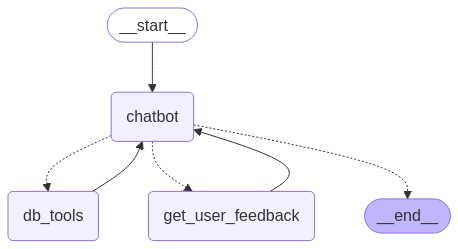

In [20]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("db_tools", db_tools_node)
graph_builder.add_node("get_user_feedback", ask_human)
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools
)
graph_builder.add_edge("get_user_feedback", "chatbot")
graph_builder.add_edge("db_tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
config = {"configurable": {"thread_id": "2"}}
for event in graph.stream(
    {
        "messages": [
            {
                "role": "user", 
                "content": "table field: user id, email, most bought product, most common payment method, last seen date"}
        ]
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()
    pass

================================ Human Message =================================

table field: user id, email, most bought product, most common payment method, last seen date
================================== Ai Message ==================================
Tool Calls:
  sql_db_shop_list_tables (call_5LfTPX2girtlTyBiJOCOVVnz)
 Call ID: call_5LfTPX2girtlTyBiJOCOVVnz
  Args:
  sql_db_finance_list_tables (call_HfatjTtXPC2ptu77Ek2kjGDH)
 Call ID: call_HfatjTtXPC2ptu77Ek2kjGDH
  Args:
================================= Tool Message =================================
Name: sql_db_finance_list_tables

"cost_prices, financial_payments"
================================== Ai Message ==================================
Tool Calls:
  sql_db_shop_schema (call_1rDcMJL1I3ChvXWDanhcASHp)
 Call ID: call_1rDcMJL1I3ChvXWDanhcASHp
  Args:
    table_names: users, orders, order_items, products
  sql_db_finance_schema (call_Hdb8GQLnHQHiSv4xf2lSTmzX)
 Call ID: call_Hdb8GQLnHQHiSv4xf2lSTmzX
  Args:
    table_names:

In [123]:
graph.get_state(config).next

()

In [121]:
for event in graph.stream(Command(resume="it is good"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Here are the potential matches for the fields you provided from the `shop` and `finance` databases:

1. **user id**
   - **Match**: `user_id` from `users` table in `shop` database
   - **Confidence**: High

2. **email**
   - **Match**: `email` from `users` table in `shop` database
   - **Confidence**: High

3. **most bought product**
   - **Match**: This can be derived from the `products` table in the `shop` database by aggregating the `order_items` table to find the product with the highest quantity sold.
   - **Confidence**: Medium (requires aggregation)

4. **most common payment method**
   - **Match**: This can be derived from the `payment_method` field in both `order_items` and `financial_payments` tables in the `shop` and `finance` databases respectively. We can aggregate to find the most common payment method.
   - **Confidence**: Medium (requires aggregation)

### SQL Query Generation

To create a

In [122]:
for event in graph.stream(
    {
        "messages": [
            {
                "role": "user", 
                "content": "give me the list of the tools that you have acccess to"}
        ]
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()
    pass

================================ Human Message =================================

give me the list of the tools that you have acccess to


================================== Ai Message ==================================

Here are the tools I have access to:

1. **Database Tools for Finance:**
   - `sql_db_finance_list_tables`: Lists all tables in the finance database.
   - `sql_db_finance_schema`: Retrieves the schema and sample rows for specified tables in the finance database.
   - `sql_db_finance_query_checker`: Checks the correctness of a SQL query before execution.
   - `sql_db_finance_query`: Executes a SQL query against the finance database.

2. **Database Tools for Shop:**
   - `sql_db_shop_list_tables`: Lists all tables in the shop database.
   - `sql_db_shop_schema`: Retrieves the schema and sample rows for specified tables in the shop database.
   - `sql_db_shop_query_checker`: Checks the correctness of a SQL query before execution.
   - `sql_db_shop_query`: Executes a SQL query against the shop database.

3. **Feedback Tool:**
   - `HumanFeedback`: Collects user feedback for final approval of the output.

If 